In [1]:
import torch 
from models import NONA_FT, NONA
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from ft_eval import RSNADataset, get_fold_indices, load_data_params
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torcheval.metrics.functional import mean_squared_error
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D

/sc/arion/projects/pandeg01a/susmaa01/nona/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cpu')
res = resnet18(weights='DEFAULT')

model_type = 'nona euclidean'
pred_sim = model_type.split(" ")
if len(pred_sim)==2:
    predictor_head = pred_sim[0]
    sim = pred_sim[1]
else:
    predictor_head= model_type 
    sim = None

model=NONA_FT(feature_extractor=res, 
                        hl_sizes=[200,50], 
                        predictor=predictor_head, 
                        similarity=sim, 
                        task='regression', 
                        dtype=torch.float32)

In [3]:
rsna_sft_weights = torch.load(f'results/rsna/models/02231621/{model_type}_0.pth', map_location=device)
model.load_state_dict(rsna_sft_weights)

<All keys matched successfully>

In [4]:
task, data_df, transform, fe, data_percentage = load_data_params('rsna')
idx_dict = get_fold_indices(data_df=data_df, seed=0, data_percentage=data_percentage)

In [25]:
def collate(batch):
    x, y = zip(*batch)
    x = torch.stack(x).to(device).to(torch.float32)
    y = torch.tensor(y, dtype=torch.float32, device=device)
    return x, y

train_dataset = RSNADataset(idx_dict['train'], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False, collate_fn=collate)

unused_dataset = RSNADataset(idx_dict['unused'][: len(idx_dict['unused']) // 6], transform=transform)
unused_loader = DataLoader(unused_dataset, batch_size=len(unused_dataset), shuffle=False, collate_fn=collate)

test_dataset = RSNADataset(idx_dict['test'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, collate_fn=collate)

In [30]:
with torch.no_grad():
    for (X_train, y_train), (X_test, y_test) in zip(train_loader, test_loader): # one batch
        y_hat_train, train_embeddings = model(X_train, X_train, y_train, get_embeddings=True)
        y_hat_test, test_embeddings = model(X_test, X_train, y_train, get_embeddings=True)

In [33]:
mse = torch.mean((y_test - y_hat_test) ** 2)
mse

tensor(0.0082)

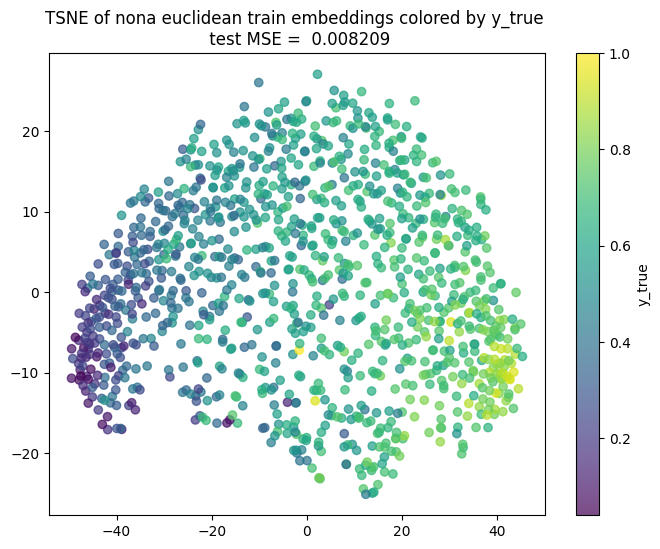

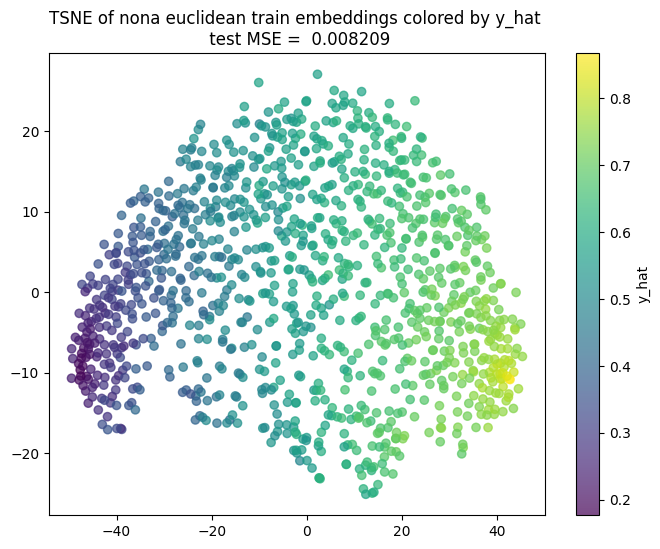

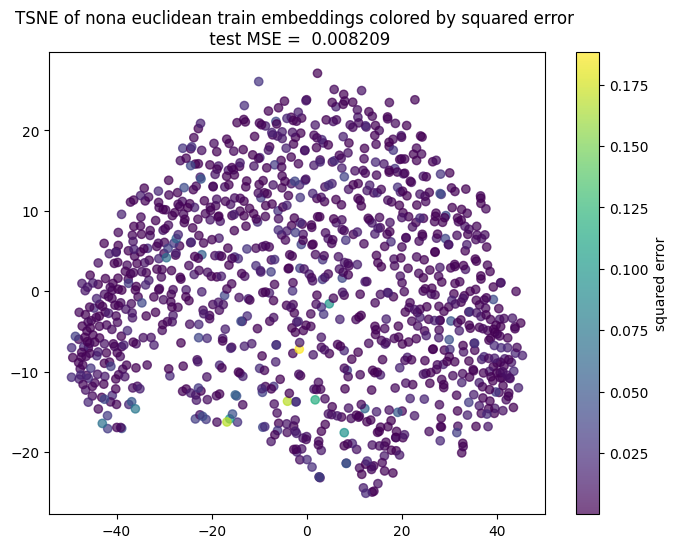

In [39]:
proj_dim = 2

embedding_set = 'train'
if embedding_set == 'train':
    embeddings = train_embeddings
    label_dict = {'y_true': y_train, 'y_hat': y_hat_train, 'squared error': (y_hat_train - y_train)**2}    
elif embedding_set == 'test':
    embeddings = test_embeddings
    label_dict = {'y_true': y_test, 'y_hat': y_hat_test, 'squared error': (y_hat_test - y_test)**2}

proj_type = 'tsne'
if proj_type == 'tsne':
    proj = TSNE(n_components=proj_dim, random_state=42)
elif proj_type == 'pca':
    proj = PCA(n_components=proj_dim, random_state=42)
elif proj_type == 'umap':
    proj = UMAP(n_components=proj_dim, random_state=42)

reduced_embeddings = proj.fit_transform(embeddings)

for label_to_vis, y in label_dict.items():
    
    title = f"{proj_type.upper()} of {model_type} {embedding_set} embeddings colored by {label_to_vis} \n test MSE = {mse.item() : 4f}"
    
    fig = plt.figure(figsize=(8, 6))#, dpi=200)
    if proj_dim == 2:
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y, cmap='viridis', alpha=0.7)
        plt.colorbar(label=label_to_vis)
        plt.title(title)

    elif proj_dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=y, cmap='viridis', alpha=0.7)
        fig.colorbar(ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=y, cmap='viridis', alpha=0.7), label=label_to_vis)
        ax.set_title(title)
    plt.show()

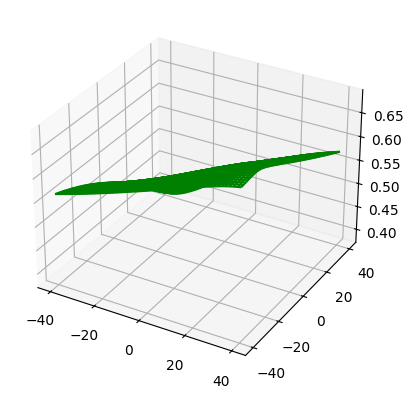

In [37]:
# Not the same as above. Outputs from above are with 50d NONA

nona = NONA(dtype=torch.float32, batch_norm=2)
grid_size = 500
scale = 40

x_grid = torch.linspace(-scale, scale, grid_size).to(torch.float32)
y_grid = torch.linspace(-scale, scale, grid_size).to(torch.float32)

X_test = torch.cartesian_prod(x_grid, y_grid)

Z = nona(X_test, torch.tensor(reduced_embeddings), y_train).reshape(grid_size,grid_size).detach()

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

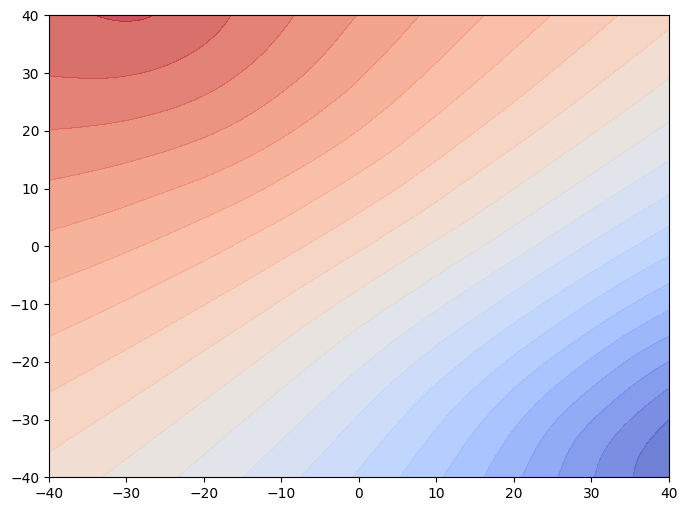

In [38]:
xx, yy = np.meshgrid(np.linspace(-scale, scale, grid_size), np.linspace(-scale, scale, grid_size))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

probabilities = nona(grid_points,  torch.tensor(reduced_embeddings), y_train).reshape(grid_size, grid_size).detach()

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

plt.show()